In [2]:
import pandas as pd
df = pd.read_csv('stocks.csv')
df.head(5)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [3]:
# Filter the dataset for rows where Company is 'NVDA'
df = df[df['Company'] == 'NVDA']

# Display the last 4 rows of the filtered dataset
df.tail(4)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
601002,2023-11-24 00:00:00-05:00,484.700012,489.209991,477.450012,477.760010,29464500,0.0,0.0,NVDA
601493,2023-11-27 00:00:00-05:00,478.000000,485.299988,476.519989,482.420013,39566200,0.0,0.0,NVDA
601984,2023-11-28 00:00:00-05:00,482.359985,483.230011,474.730011,478.209991,40089000,0.0,0.0,NVDA
602475,2023-11-29 00:00:00-05:00,483.790009,487.619904,478.635406,480.734985,20498046,0.0,0.0,NVDA


In [4]:
df = df[['Date','Close']]
df.tail(4)

,Date,Close
601002,2023-11-24 00:00:00-05:00,477.760010
601493,2023-11-27 00:00:00-05:00,482.420013
601984,2023-11-28 00:00:00-05:00,478.209991
602475,2023-11-29 00:00:00-05:00,480.734985


In [5]:
import datetime

def str_to_datetime(s):
    """
    Converts a string in the format 'YYYY-MM-DD HH:MM:SS-TZ' to a date object (YYYY-MM-DD).
    
    Args:
    - s (str): The input string containing the timestamp.
    
    Returns:
    - datetime.date: A date object with year, month, and day.
    """
    # Extract the date part (before the space)
    date_part = s.split(' ')[0]
    year, month, day = map(int, date_part.split('-'))
    return datetime.date(year, month, day)

In [6]:
# Apply the function to the 'Date' column
df['Date'] = df['Date'].apply(str_to_datetime)

In [7]:
df.index = df.pop('Date')

In [8]:
df

,Close
Date,
2018-11-29,39.037853
2018-11-30,40.543697
2018-12-03,42.183514
2018-12-04,38.975834
2018-12-06,39.268578
...,...
2023-11-22,487.160004
2023-11-24,477.760010
2023-11-27,482.420013


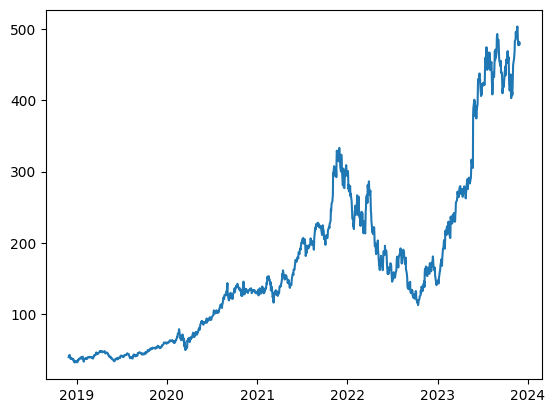

In [9]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [10]:

import numpy as np
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)  # Convert to datetime
    last_date = pd.to_datetime(last_date_str)

    # Ensure the DataFrame has a DateTimeIndex
    if not isinstance(dataframe.index, pd.DatetimeIndex):
        dataframe.index = pd.to_datetime(dataframe.index)

    target_date = first_date
    dates = []
    X, Y = [], []
    last_time = False

    while True:
        # Get the last (n+1) rows up to the target date
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            # Skip if not enough data
            print(f"Skipping target date {target_date}: insufficient data")
            if last_time:
                break
            next_target_date = target_date + datetime.timedelta(days=1)
            if next_target_date > last_date:
                break
            target_date = next_target_date
            continue

        # Extract features (X) and target (Y)
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next target date (7 days later)
        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if len(next_week) < 2:
            break  # No more data to process

        next_target_date = next_week.index[1]  # Get the next valid date
        if last_time:
            break

        target_date = next_target_date

        if target_date >= last_date:
            last_time = True

    # Create a new DataFrame for the results
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    # Add feature columns
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n - i}'] = X[:, i]

    # Add target column
    ret_df['Target'] = Y

    return ret_df

windowed_df = df_to_windowed_df(df, '2018-11-29', '2023-11-29', n=3)
print(windowed_df)

Skipping target date 2018-11-29 00:00:00: insufficient data
Skipping target date 2018-11-30 00:00:00: insufficient data
Skipping target date 2018-12-01 00:00:00: insufficient data
Skipping target date 2018-12-02 00:00:00: insufficient data
Skipping target date 2018-12-03 00:00:00: insufficient data
     Target Date    Target-3    Target-2    Target-1      Target
0     2018-12-04   39.037853   40.543697   42.183514   38.975834
1     2018-12-06   40.543697   42.183514   38.975834   39.268578
2     2018-12-07   42.183514   38.975834   39.268578   36.619076
3     2018-12-10   38.975834   39.268578   36.619076   37.673412
4     2018-12-11   39.268578   36.619076   37.673412   36.762966
...          ...         ...         ...         ...         ...
1250  2023-11-22  492.980011  504.089996  499.440002  487.160004
1251  2023-11-24  504.089996  499.440002  487.160004  477.760010
1252  2023-11-27  499.440002  487.160004  477.760010  482.420013
1253  2023-11-28  487.160004  477.760010  482.4200

In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1255,), (1255, 3, 1), (1255,))

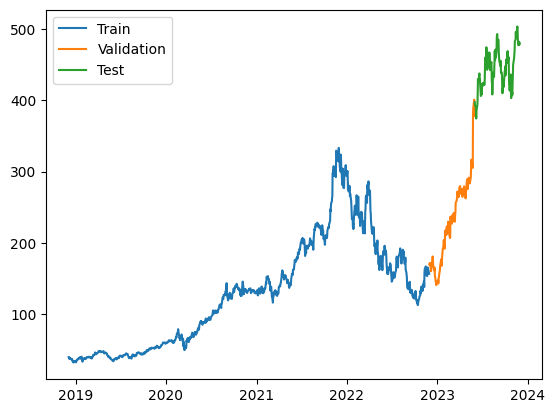

In [12]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21799.8926 - mean_absolute_error: 126.3285 - val_loss: 55026.5000 - val_mean_absolute_error: 227.5896
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20795.9766 - mean_absolute_error: 121.5771 - val_loss: 48786.6562 - val_mean_absolute_error: 213.3483
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16102.8691 - mean_absolute_error: 100.0487 - val_loss: 31534.6172 - val_mean_absolute_error: 168.1835
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8423.2178 - mean_absolute_error: 71.9464 - val_loss: 16175.0977 - val_mean_absolute_error: 113.8393
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5166.3750 - mean_absolute_error: 56.1681 - val_loss: 9216.7910 - val_mean_absolute_error: 80.0959
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1618.4196 - mean_absolute_error: 21.2754 - val_loss: 3451.7605 - val_mean_absolute_error: 42.6199
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2m